In [1]:
from configs.config import vae_config

letter = "aleph"
latent_dims = 5
vae_config.latent_dims = latent_dims
use_gpu = True

In [2]:
import torch
from models.vae import VariationalAutoencoder

vae = VariationalAutoencoder(vae_config)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

In [3]:
filename = f'{letter}_vae_{latent_dims}_dims.pth'
import urllib
# load on cpu
vae.load_state_dict(torch.load('./pretrained_models/'+filename, map_location=device))
print('done')

done


In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from src.datasets import GraphemesDataset
data_dir = "datasets/raw/base_dataset/"

img_transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = GraphemesDataset(data_dir, train=True, test_size=1, by_letter=letter, transform=img_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [14]:
# convert all images to their latent representation using the encoder

# images will be a list of all images in the dataset in the same order as the labels and latent_representations lists
# you should add all images from all batches to the list and make sure to
# convert it to PIL images of 28 x 28

from PIL import Image        

images = []
latent_representations = []
labels = []
with torch.no_grad():
    for i, (x, y) in enumerate(dataloader):

        for tensor in x:
            # Remove the batch dimension and convert the tensor to a numpy array
            image_np = tensor.squeeze().cpu().numpy()
            # Convert numpy array to PIL image
            pil_image = Image.fromarray((image_np * 255).astype('uint8'), mode='L')
            images.append(pil_image)
        

        x = x.to(device)
        mu, logvar = vae.encoder(x)
        latent_representations.append(mu)
        labels.append(y)

latent_representations = torch.cat(latent_representations).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

In [15]:
# if latent_dims == 3 plot 3D, else 2D
z = latent_representations
y = labels
if latent_dims == 3:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=y, cmap='tab10')
    ax.set_xlabel('z1')
    ax.set_ylabel('z2')
    ax.set_zlabel('z3')
    plt.show()

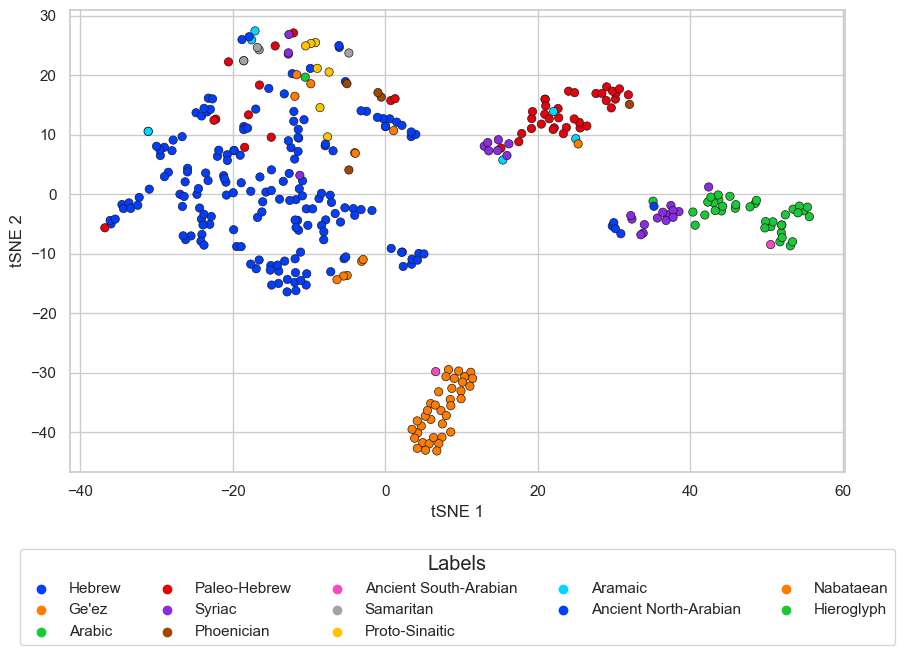

In [19]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# tsne = TSNE(n_components=2, perplexity=30) 
tsne = TSNE(n_components=2, perplexity=15) 
X_r = tsne.fit_transform(z)

labels = [dataset.classes[i] for i in y]

# Create a DataFrame to hold the data
import pandas as pd
data = pd.DataFrame({'tSNE 1': X_r[:, 0], 'tSNE 2': X_r[:, 1], 'Label': labels})

# Set up Seaborn style
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='tSNE 1', y='tSNE 2', hue='Label', data=data, edgecolor='k', palette='bright')

# Move the legend to the upper center and set the number of columns to 3
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, title='Labels')
plt.setp(legend.get_title(), fontsize='large')

# Show plot
plt.show()


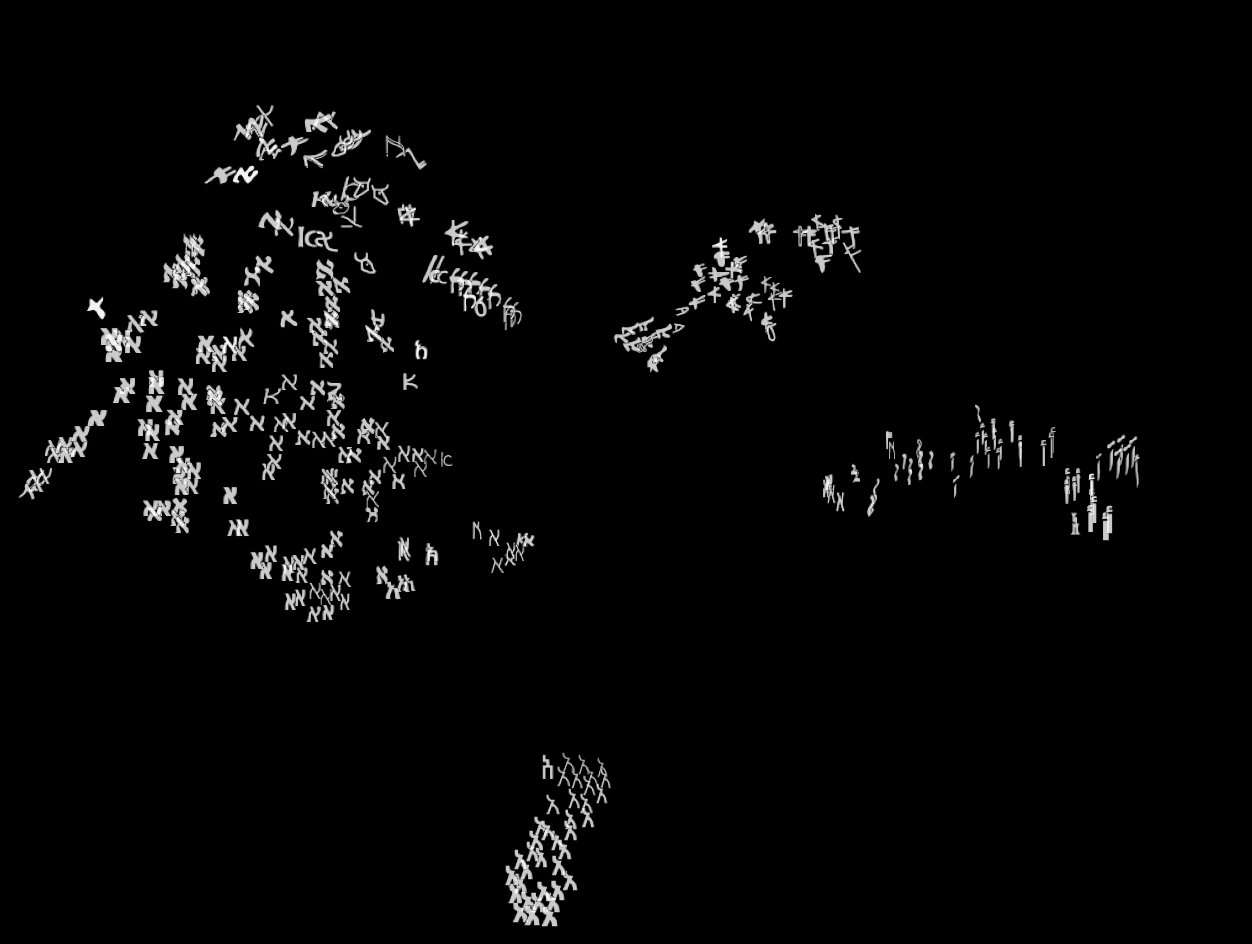

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the 'images', 'tx', and 'ty' variables defined

width = 1000
height = 750
max_dim = 100

tx1, tx2 = X_r[:,0], X_r[:,1]
tx1 = (tx1-np.min(tx1)) / (np.max(tx1) - np.min(tx1))
tx2 = (tx2-np.min(tx2)) / (np.max(tx2) - np.min(tx2))

plt.figure(figsize=(16, 12), facecolor='black')  # Set the background color to black

for grapheme, x1, x2 in zip(images, tx1, tx2):
    # Convert PIL image to OpenCV format
    grapheme_cv2 = cv2.cvtColor(np.array(grapheme), cv2.COLOR_RGBA2BGRA)

    # Convert image to grayscale
    gray = cv2.cvtColor(grapheme_cv2, cv2.COLOR_BGRA2GRAY)

    # Applying thresholding technique
    _, alpha = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

    # Split channels of the colored image
    b, g, r, _ = cv2.split(grapheme_cv2)

    # Create the alpha channel
    rgba = [b, g, r, alpha]

    # Merge channels to create the final image
    grapheme_no_bg = cv2.merge(rgba, 4)

    x_coord = int((width - max_dim) * x1)
    y_coord = int((height - max_dim) * x2)

    plt.imshow(grapheme_no_bg, extent=[x_coord, x_coord + grapheme.width, y_coord, y_coord + grapheme.height], alpha=0.8)

plt.xlim(0, width)
plt.ylim(0, height)

plt.axis('off')  # Remove the axis ticks and labels
plt.grid(False)  # Remove the grid

plt.show()
